In [76]:
import kagglehub
import pandas as pd
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import os

In [77]:
path = kagglehub.dataset_download("fedesoriano/body-fat-prediction-dataset")
print("Path to dataset files:", path)


Path to dataset files: /root/.cache/kagglehub/datasets/fedesoriano/body-fat-prediction-dataset/versions/1


In [78]:
file_path = "/root/.cache/kagglehub/datasets/fedesoriano/body-fat-prediction-dataset/versions/1/bodyfat.csv"  # Remplacez par le vrai nom de fichier
data = pd.read_csv(file_path)

print(data.head())

   Density  BodyFat  Age  Weight  Height  Neck  Chest  Abdomen    Hip  Thigh  \
0   1.0708     12.3   23  154.25   67.75  36.2   93.1     85.2   94.5   59.0   
1   1.0853      6.1   22  173.25   72.25  38.5   93.6     83.0   98.7   58.7   
2   1.0414     25.3   22  154.00   66.25  34.0   95.8     87.9   99.2   59.6   
3   1.0751     10.4   26  184.75   72.25  37.4  101.8     86.4  101.2   60.1   
4   1.0340     28.7   24  184.25   71.25  34.4   97.3    100.0  101.9   63.2   

   Knee  Ankle  Biceps  Forearm  Wrist  
0  37.3   21.9    32.0     27.4   17.1  
1  37.3   23.4    30.5     28.9   18.2  
2  38.9   24.0    28.8     25.2   16.6  
3  37.3   22.8    32.4     29.4   18.2  
4  42.2   24.0    32.2     27.7   17.7  


In [79]:
columns_to_use = [
    "Density", "BodyFat", "Age", "Weight", "Height",
    "Neck", "Chest", "Abdomen", "Hip", "Thigh",
    "Knee", "Ankle", "Biceps", "Forearm", "Wrist"
]

data = data[columns_to_use]

np.random.seed(42)
data["Sportif"] = np.where(
    (data["BodyFat"] < 15) | (np.random.rand(len(data)) < 0.2),  # Critère BodyFat ou probabilité de 20%
    1,
    0
)

data = data.dropna()

print(data.count())

Density    252
BodyFat    252
Age        252
Weight     252
Height     252
Neck       252
Chest      252
Abdomen    252
Hip        252
Thigh      252
Knee       252
Ankle      252
Biceps     252
Forearm    252
Wrist      252
Sportif    252
dtype: int64


In [80]:
# Caractéristiques (X) et label (y)
X = data.drop("Sportif", axis=1)
y = data["Sportif"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

DataFrame

In [81]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Sortie binaire
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [82]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=32, verbose=1)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.5661 - loss: 0.6737 - val_accuracy: 0.6341 - val_loss: 0.6617
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7079 - loss: 0.6006 - val_accuracy: 0.6341 - val_loss: 0.6510
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7391 - loss: 0.5392 - val_accuracy: 0.6341 - val_loss: 0.6554
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7183 - loss: 0.5747 - val_accuracy: 0.6341 - val_loss: 0.6648
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7813 - loss: 0.5133 - val_accuracy: 0.6341 - val_loss: 0.6654
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7493 - loss: 0.5447 - val_accuracy: 0.6829 - val_loss: 0.6441
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7837 - loss: 0.4783 - val_accuracy: 0.6829 - val_loss: 0.6261
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7876 - loss: 0.5059 - val_accuracy: 0.6829 - val_loss: 0.5988


In [83]:
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Rapport de classification
print(classification_report(y_test, y_pred))

# Score ROC-AUC
roc_auc = roc_auc_score(y_test, model.predict(X_test))
print(f"ROC-AUC Score : {roc_auc:.2f}")

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
              precision    recall  f1-score   support

           0       0.69      0.80      0.74        25
           1       0.77      0.65      0.71        26

    accuracy                           0.73        51
   macro avg       0.73      0.73      0.72        51
weighted avg       0.73      0.73      0.72        51

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
ROC-AUC Score : 0.76


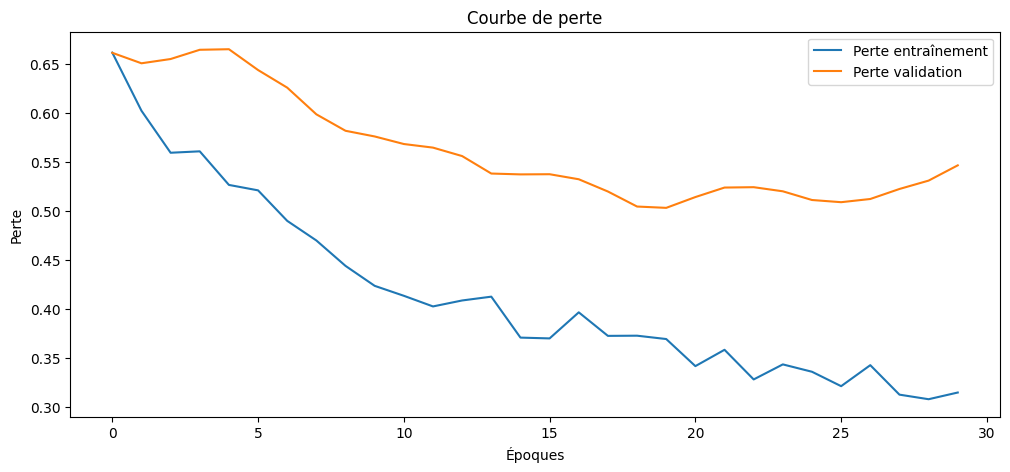

In [84]:
# Courbe de perte
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Perte entraînement')
plt.plot(history.history['val_loss'], label='Perte validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.title('Courbe de perte')
plt.show()


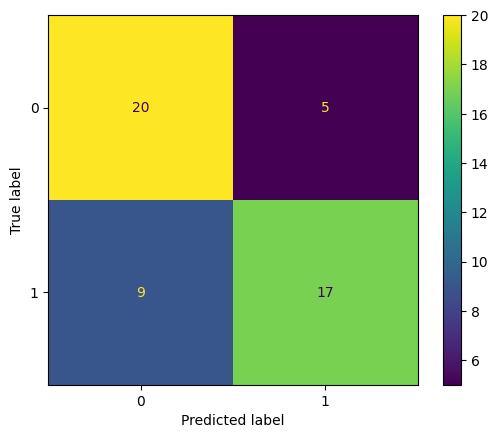

In [85]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()


In [86]:
test_data = {
    "Density": 1.05,
    "BodyFat": 12.0,
    "Age": 30,
    "Weight": 180,
    "Height": 70,
    "Neck": 40,
    "Chest": 100,
    "Abdomen": 85,
    "Hip": 95,
    "Thigh": 60,
    "Knee": 40,
    "Ankle": 23,
    "Biceps": 35,
    "Forearm": 30,
    "Wrist": 18
}

# Convertir les données en DataFrame
test_df = pd.DataFrame([test_data])

# Normaliser les données avec le même scaler utilisé pour l'entraînement
test_df_normalized = scaler.transform(test_df)

# Faire une prédiction
prediction = model.predict(test_df_normalized)

# Interprétation de la prédiction
is_sportif = (prediction[0][0] > 0.5)  # Seuil de 0.5 pour la classification
print(f"Prédiction : {'Sportif' if is_sportif else 'Non Sportif'}")
print(f"Probabilité : {prediction[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prédiction : Sportif
Probabilité : 0.63


# Avec des images cette fois-ci

In [87]:
import kagglehub
!pip install "deeplake<4" #.load() est dépressié en version >4
import deeplake
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import requests

##Chargement des Dataset

In [88]:
# Dataset depuis: https://www.kaggle.com/datasets/ahmadahmadzada/images2000?resource=download
path = kagglehub.dataset_download("ahmadahmadzada/images2000")

# Dataset depuis: https://app.activeloop.ai/activeloop/lsp-train/firstdbf9474d461a19e9333c2fd19b46115348f
ds = deeplake.load("hub://activeloop/lsp-train")

-

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/lsp-train



/

hub://activeloop/lsp-train loaded successfully.



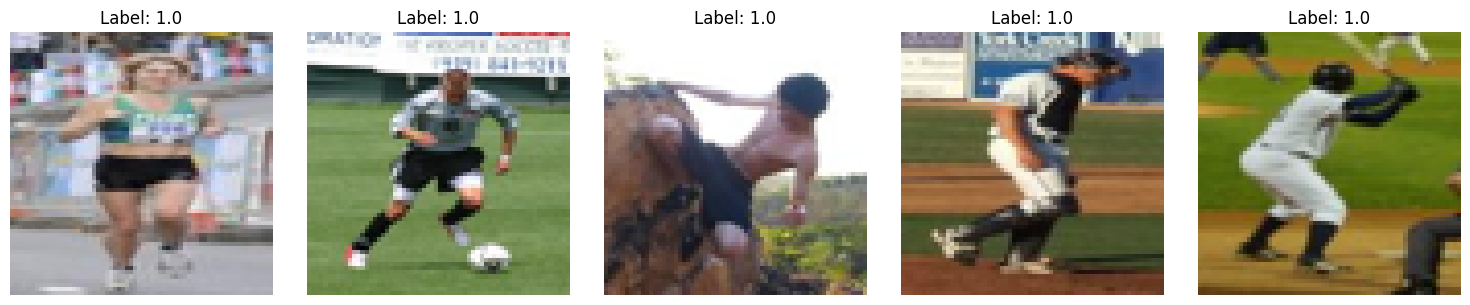

DataFrame des images Sportif :
     0    1    2    3    4    5    6    7    8    9  ...  12279  12280  12281  \
0  187  186  203  196  195  211  215  214  229  220  ...    173    173    183   
1  168  177  192  191  204  215  171  187  205  158  ...    115    140     82   
2  255  255  255  255  255  255  255  255  255  255  ...     86     69     83   
3  114  105  121  135  127  142  152  143  159  166  ...    113     68     45   
4  108  128   14  108  127   27  112  126   53   98  ...    114     82     31   

   12282  12283  12284  12285  12286  12287  Sportif  
0    172    172    182    172    172    182      1.0  
1    117    142     84    122    147     89      1.0  
2     91     72     62    176    154    112      1.0  
3    104     61     40    100     57     38      1.0  
4    114     82     31    114     82     32      1.0  

[5 rows x 12289 columns]


In [89]:
images = ds['images'][:5]

target_size = (64, 64)  # Taille cible pour les images

# Créer un label constant "Sportif" avec la valeur 1 pour toutes les images du premier dataset
labels = np.ones(len(images))

image_data = []
for img in images:
    img_np = np.array(img)
    img_resized = Image.fromarray(img_np).resize(target_size)
    image_data.append(np.array(img_resized).reshape(-1))  # Aplatir l'image en un vecteur 1D

# Créer un DataFrame pour les images "Sportif"
df_sportif = pd.DataFrame(image_data)
df_sportif['Sportif'] = labels  # Ajouter la colonne des labels "Sportif"

plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = np.array(image_data[i]).reshape(target_size[0], target_size[1], 3)
    plt.imshow(img.astype('uint8'))
    plt.axis('off')
    plt.title(f"Label: {labels[i]}")

plt.tight_layout()
plt.show()

# Afficher les premières valeurs du DF
print("DataFrame des images Sportif :")
print(df_sportif.head())


DataFrame chargé avec 5 images.
     0    1    2    3    4    5    6    7    8    9  ...  12279  12280  12281  \
0  150  146  156  144  141  151  145  142  152  154  ...    195    188    231   
1  106  104  239  108  106  241  108  106  240  107  ...    117    116    250   
2  179  111   96  103   54   44  122   85   71  224  ...     75     86     99   
3  126  114  100  128  109   88  165  141  106  166  ...    125    121    109   
4  254  254  253  255  255  255  235  232  219   95  ...     74     35     31   

   12282  12283  12284  12285  12286  12287  Sportif  
0    215    221    210    149    156    142      0.0  
1    116    115    250    117    116    251      0.0  
2     74     86    102     73     85     99      0.0  
3    130    126    116    139    135    129      0.0  
4    108     51     26    199    116     59      0.0  

[5 rows x 12289 columns]


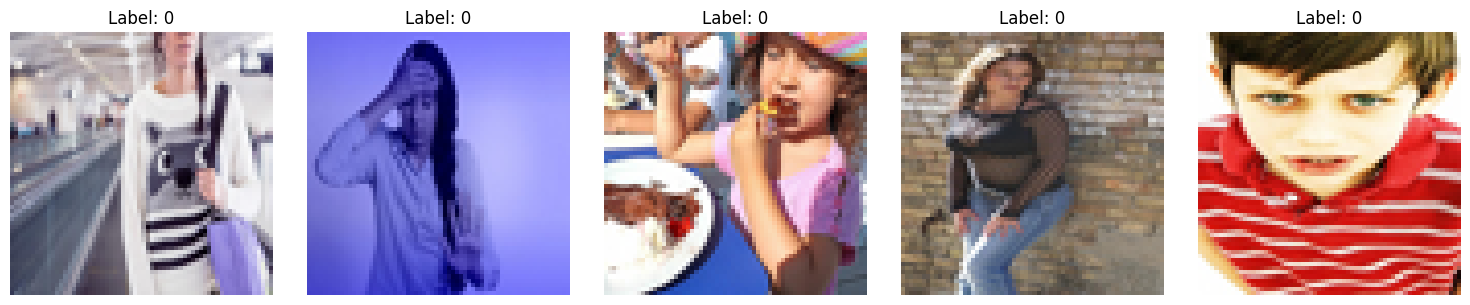

In [90]:
def is_image_file(filename):
    """Vérifie si un fichier est un format d'image valide."""
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff')
    return filename.lower().endswith(valid_extensions)

def load_and_flatten_images(image_dir):
    """Charge et aplatit les images depuis un répertoire, puis les stocke dans un DataFrame."""
    image_files = [f for f in os.listdir(image_dir) if is_image_file(f)]
    image_files = image_files[:5]

    if not image_files:
        print(f"Aucune image valide trouvée dans le répertoire : {image_dir}")
        return None

    # Préparer les données
    image_data = []
    for image_file in image_files:
        image_path = os.path.join(image_dir, image_file)
        try:
            # Charger l'image
            img = Image.open(image_path).convert('RGB')
            img_resized = img.resize((64, 64))  # Redimensionner pour normaliser la taille
            img_np = np.array(img_resized)
            image_data.append(img_np.flatten())  # Aplatir en un vecteur 1D
        except Exception as e:
            print(f"Erreur avec le fichier {image_file}: {e}")

    # Créer les labels
    labels = np.zeros(len(image_data))

    df_non_sportif = pd.DataFrame(image_data)
    df_non_sportif['Sportif'] = labels

    return df_non_sportif

image_dir = "/root/.cache/kagglehub/datasets/ahmadahmadzada/images2000/versions/1/images/images"

# Charger les images et les aplatir
df_images = load_and_flatten_images(image_dir)

if df_images is not None:
    print(f"DataFrame chargé avec {len(df_images)} images.")
    print(df_images.head())

    # Visualisation des images
    plt.figure(figsize=(15, 3))
    for i in range(5):
        img_array = df_images.iloc[i, :-1].values.reshape(64, 64, 3)  # Reformater pour visualisation
        plt.subplot(1, 5, i + 1)
        plt.imshow(img_array.astype('uint8'))
        plt.axis('off')
        plt.title("Label: 0")
    plt.tight_layout()
    plt.show()
else:
    print("Aucun dataframe généré.")


In [91]:
# Concaténer les deux DataFrames
df_combined = pd.concat([df_sportif, df_images], ignore_index=True)

print("DataFrame combiné (Sportif et Non Sportif) :")
print(df_combined.head())
print(df_combined.tail())

DataFrame combiné (Sportif et Non Sportif) :
     0    1    2    3    4    5    6    7    8    9  ...  12279  12280  12281  \
0  187  186  203  196  195  211  215  214  229  220  ...    173    173    183   
1  168  177  192  191  204  215  171  187  205  158  ...    115    140     82   
2  255  255  255  255  255  255  255  255  255  255  ...     86     69     83   
3  114  105  121  135  127  142  152  143  159  166  ...    113     68     45   
4  108  128   14  108  127   27  112  126   53   98  ...    114     82     31   

   12282  12283  12284  12285  12286  12287  Sportif  
0    172    172    182    172    172    182      1.0  
1    117    142     84    122    147     89      1.0  
2     91     72     62    176    154    112      1.0  
3    104     61     40    100     57     38      1.0  
4    114     82     31    114     82     32      1.0  

[5 rows x 12289 columns]
     0    1    2    3    4    5    6    7    8    9  ...  12279  12280  12281  \
5  150  146  156  144  141  151

##Entrainement du modèle

In [92]:
X = df_combined.drop(columns=['Sportif']).values
y = df_combined['Sportif'].values

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [94]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [95]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Évaluer le modèle
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Rapport de classification:")
print(classification_report(y_test, y_pred))

Accuracy: 0.5
Rapport de classification:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [96]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


X_train shape: (8, 12288)
y_train shape: (8,)


In [97]:
# Create an MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,
                    solver='sgd', verbose=10, random_state=1,
                    learning_rate_init=.001)

# Train the model
mlp.fit(X_train, y_train)

# Make predictions on the test set
y_pred = mlp.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Iteration 1, loss = 0.97996043
Iteration 2, loss = 0.22456506
Iteration 3, loss = 0.10025062
Iteration 4, loss = 0.05639257
Iteration 5, loss = 0.03479553
Iteration 6, loss = 0.02343535
Iteration 7, loss = 0.01610599
Iteration 8, loss = 0.01146098
Iteration 9, loss = 0.00846525
Iteration 10, loss = 0.00649159
Accuracy: 0.5


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Réseau de neurones

In [98]:
X = df_combined.drop(columns=['Sportif']).values
y = df_combined['Sportif'].values

# Reshape pour CNN : (n_samples, height, width, channels)
X = X.reshape(-1, 64, 64, 3)
y = y.astype(int)  # S'assurer que les labels sont des entiers

# Diviser en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisation des pixels (valeurs entre 0 et 1)
X_train = X_train / 255.0
X_test = X_test / 255.0

In [108]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (8, 64, 64, 3)
y_train shape: (8, 2)


In [99]:
# Convertir les labels en one-hot encoding pour la classification
num_classes = len(set(y))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')  # Softmax pour la classification multi-classes
])

# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entraîner le modèle
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), batch_size=32)

# Évaluer le modèle
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.5000 - loss: 0.7076 - val_accuracy: 0.5000 - val_loss: 1.4673
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.5000 - loss: 1.4830 - val_accuracy: 0.5000 - val_loss: 0.5959
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.7500 - loss: 0.5672 - val_accuracy: 0.5000 - val_loss: 0.7246
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.5000 - loss: 0.7294 - val_accuracy: 0.5000 - val_loss: 0.5608
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step - accuracy: 0.8750 - loss: 0.4583 - val_accuracy: 1.0000 - val_loss: 0.5130
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.8750 - loss: 0.4127 - val_accuracy: 0.5000 - val_loss: 0.5088
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step - accuracy: 0.7500 - loss: 0.4219 - val_accuracy: 1.0000 - val_loss: 0.4422
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step - accuracy: 0.8750 - loss: 0.3239 - val_accuracy: 1.0000 - val_loss: 0.

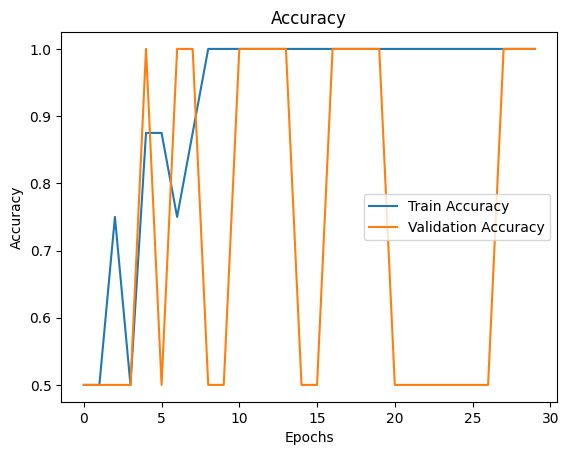

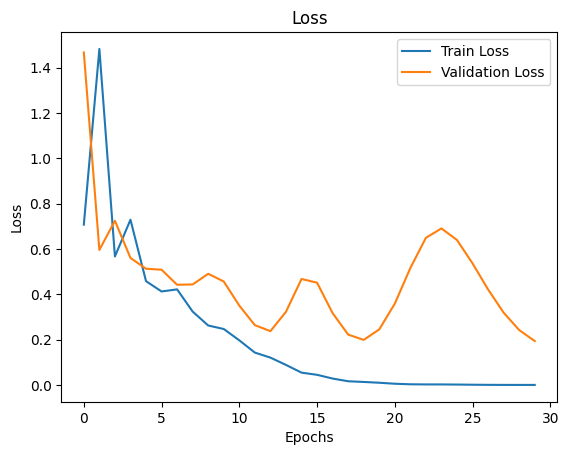

In [100]:
# Courbe de précision
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Courbe de perte
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [109]:
url = 'https://www.vousnousils.fr/wp-content/uploads/2014/06/sportif-haut-niveau.jpg'

response = requests.get(url, stream=True)
response.raise_for_status()  # Vérifier que la requête a réussi

# Ouvrir et préparer l'image
new_image = Image.open(response.raw).convert('RGB')  # Convertir en RGB
new_image = new_image.resize((64, 64))  # Redimensionner à 64x64 pixels

# Convertir en tableau numpy
new_image_array = np.array(new_image).reshape(1, 64, 64, 3)  # Ajouter une dimension batch
new_image_array = new_image_array / 255.0  # Normaliser les valeurs des pixels (0-1)
print(new_image_array.shape)

# Prédire avec le modèle
prediction = model.predict(new_image_array)
predicted_class = np.argmax(prediction)
print("Classe prédite :", predicted_class)

(1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Classe prédite : 0
